# Analysis & Visualization of Produced Water Chemistry for Environmental & Agricultural Utilization

In [4]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import sklearn
from wqchartpy import triangle_piper

## DATA CLEANING & FILTERING

In [5]:
# Load the data from the CSV files
df1 = pd.read_csv('../data/split_1_USGSPWDBv2.3n.csv', low_memory=False)
df2 = pd.read_csv('../data/split_2_USGSPWDBv2.3n.csv', low_memory=False)
df3 = pd.read_csv('../data/split_3_USGSPWDBv2.3n.csv', low_memory=False)

# Concatenate the dataframes
frames = [df1, df2, df3]
df_merged = pd.concat(frames, ignore_index=True)

# Save the concatenated dataframe to a new CSV file
df_merged.to_csv('../data/df_merged.csv', index=False)

In [6]:
# List of columns to be removed
columns_to_remove = [
    "IDDB", "SOURCE", "REFERENCE", "LATLONGAPX", "USGSREGION", "BASINCODE", 
    "STATECODE", "COUNTYCODE", "FIELD", "FIELDCODE", "WELLCODE", "TOWNRANGE", 
    "REGDIST", "LOC", "QUAD", "DAY", "DATECOMP", "DATEANALYS", "METHOD", 
    "OPERATOR", "PERMIT", "DFORM", "GROUP", "MEMBER", "AGECODE", "ERA", 
    "PERIOD", "EPOCH", "LAB", "REMARKS", "LITHOLOGY", "POROSITY", "TEMP", 
    "PRESSURE", "SG", "SPGRAV", "SPGRAVT", "RESIS", "RESIST", "PH", "PHT", 
    "EHORP", "COND", "CONDT", "TURBIDITY", "HEM", "MBAS","TDS","TDSCALC", "TSS", "CHARGEBAL", 
    "ACIDITY", "DIC", "DOC", "TOC", "CN", "BOD", "COD", "BENZENE", "TOLUENE", 
    "ETHYLBENZ", "XYLENE", "ACETATE", "BUTYRATE", "FORMATE", "LACTATE", 
    "PHENOLS", "PERC", "PROPIONATE", "PYRUVATE", "VALERATE", "ORGACIDS", 
    "Ar", "CH4", "C2H6", "CO2", "H2", "H2S", "He", "N2", "NH3", "O2", "ALPHA", 
    "BETA", "dD", "H3", "d7Li", "d11B", "d13C", "C14", "d18O", "d34S", 
    "d37Cl", "K40", "d81Br", "Sr87Sr86", "I129", "Rn222", "Ra226", "Ra228", 
    "cull_PH", "cull_MgCa", "cull_KCl", "cull_K5Na", "Ag", "Al", "As", "Au", 
    "B", "BO3", "Be", "Bi", "Cd", "Co", "Cr", "Cs", "Cu", "F", "FeS", "FeAl", 
    "FeAl2O3", "Hg", "I", "Mn", "Mo", "N", "NO2", "NO3", "NO3NO2", "NH4", 
    "TKN", "Ni", "OH", "P", "PO4", "Pb", "Rh", "Rb", "S", "SO3", "HS", "Sb", 
    "Sc", "Se", "Sn", "Ti", "Tl", "U", "V", "W", "Zn"
]

# Remove the specified columns
df_limited_column = df_merged.drop(columns=columns_to_remove, errors='ignore')

# Display the updated merged dataframe
df_limited_column.to_csv('../data/df_limited_column.csv', index=False)

In [7]:
# Add column "BASIN_CATEGORY" to df_filtered to aid in later filtering

# Define the basin categories
basin_categories = {
    'Anadarko Basin': ['Amarillo Arch', 'Anadarko', 'Anadarko - Chautauqua Platform', 'Anadarko - Southern Oklahoma'],
    'Appalachian Basin': ['Appalachian', 'Black Warrior'],
    'Gulf Coast Basin': ['Arkla', 'Gulf Coast'],
    'Oklahoma Platform Basins': ['Arkoma', 'Arkoma - Chautauqua Platform', 'Central Kansas Uplift', 
                                                'Chautauqua Platform', 'Cherokee', 'Kansas Basins', 'Nemaha Uplift', 
                                                'Sedgwick', 'Southern Oklahoma'],
    'Fort Worth Basin': ['Bend Arch', 'Fort Worth'],
    'Rocky Mountain Basins': ['Big Horn', 'Black Mesa', 'Denver', 'Green River', 'Paradox', 'Piceance', 
                              'Powder River', 'San Juan', 'Uinta', 'Wind River'],
    'Illinois Basin': ['Illinois'],
    'Michigan Basin': ['Michigan'],
    'Permian Basin': ['Palo Duro', 'Permian'],
    'Williston Basin': ['Williston']
}

# Create a reverse mapping from specific basin to category
basin_to_category = {specific: category for category, specifics in basin_categories.items() for specific in specifics}

df_basins_categorized = df_limited_column.copy()

# Map the 'BASIN' column to a new 'BASIN_CATEGORY' column
df_basins_categorized['BASIN_CATEGORY'] = df_basins_categorized['BASIN'].map(basin_to_category)

# Drop rows that don't have a basin category (i.e., not in your list)
df_basins_categorized = df_basins_categorized.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_basins_categorized.to_csv('../data/df_basins_categorized.csv', index=False)

In [8]:
# Remove rows where TDSUSGS <= 35000 (sea water to eliminate all colebed methane produced water and also the failing analyses)
df_filtered = df_limited_column[df_limited_column['TDSUSGS'] > 35000]

# Save the filtered dataframe to a new CSV file
df_filtered.to_csv('../data/df_filtered_TDS.csv', index=False)

In [9]:
# Fill NaN values in 'KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg' with zeros for calculation
for col in ['KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg']:
    df_filtered[col].fillna(0, inplace=True)

# First, we'll fill NaN values in 'KNa' and 'K' with zeros for the calculation.
df_filtered['KNa'].fillna(0, inplace=True)
df_filtered['K'].fillna(0, inplace=True)

# Apply conditions to calculate 'Na'
# If 'Na' is missing and both 'KNa' and 'K' are present, populate 'Na' with 'KNa' - 'K'
# If 'Na' is missing and 'KNa' is present but 'K' is not, populate 'Na' with 'KNa'

na_mask = df_filtered['Na'].isna()
na_present = df_filtered['Na'] > 0
kna_present = df_filtered['KNa'] > 0
k_present = df_filtered['K'] > 0
k_missing = df_filtered['K'] == 0

df_filtered.loc[k_missing & na_present & kna_present, 'K'] = df_filtered['KNa'] - df_filtered['Na']
df_filtered.loc[na_mask & kna_present & k_present, 'Na'] = df_filtered['KNa'] - df_filtered['K']
df_filtered.loc[na_mask & kna_present & ~k_present, 'Na'] = df_filtered['KNa']

# Remove rows where 'Na' is still missing
df_filtered.dropna(subset=['Na'], inplace=True)

# Remove rows where 'Cl' is missing
df_filtered.dropna(subset=['Cl'], inplace=True)

# Save the updated dataframe 
df_filtered.to_csv('../data/df_filtered_Na_Cl.csv', index=False)

C:\Users\ajuar\AppData\Local\Temp\ipykernel_23404\3587715086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(0, inplace=True)
C:\Users\ajuar\AppData\Local\Temp\ipykernel_23404\3587715086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['KNa'].fillna(0, inplace=True)
C:\Users\ajuar\AppData\Local\Temp\ipykernel_23404\3587715086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['K']

In [10]:
#To calculate the molar concentrations from concentrations given in ppm (parts per million) or mg/L,
#these values need to be converted into moles per liter (M). The formula to convert ppm or mg/L to M is:

                #Molarity (M)=Concentration (mg/L)/ Molar Mass (g/mol) 

#This calculation assumes that 1 ppm is equivalent to 1 mg/L. The molar mass of each element or compound (Na, Ca, Cl, SO4, and Mg) 
#is a constant value based on its atomic or molecular weight.

#Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2) which represent likely unnatural combinations
# Convert concentrations from ppm (mg/L) to Molarity (M)
molar_masses = {'Na': 22.99, 'Ca': 40.08, 'Cl': 35.45, 'SO4': 96.06, 'Mg': 24.305}
for element, molar_mass in molar_masses.items():
    df_filtered[element + '_M'] = df_filtered[element] / molar_mass

# Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2)
condition = (df_filtered['Na_M'] > df_filtered['Ca_M']) & \
            (df_filtered['Cl_M'] > df_filtered['SO4_M']) & \
            (df_filtered['Ca_M'] > df_filtered['Mg_M'] / 2)


df_filtered = df_filtered[condition]

# Save the updated dataframe
df_filtered.to_csv('../data/df_filtered_corrected_elemental_ratios.csv', index=False)

C:\Users\ajuar\AppData\Local\Temp\ipykernel_23404\2291718414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
C:\Users\ajuar\AppData\Local\Temp\ipykernel_23404\2291718414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
C:\Users\ajuar\AppData\Local\Temp\ipykernel_23404\2291718414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [11]:
# Filter out rows where USGS charge balance is not between -10 and +10
df_filtered = df_filtered[df_filtered['chargebalance'].between(-10, 10)]

# Save the updated dataframe
df_filtered.to_csv('../data/df_filtered_chargebalance.csv', index=False)

In [12]:
# Calculate charge balance
df_filtered['Cations'] = (df_filtered['Na_M'] * 1) + (df_filtered['Ca_M'] * 2) + (df_filtered['Mg_M'] * 2)
df_filtered['Anions'] = (df_filtered['Cl_M'] * 1) + (df_filtered['SO4_M'] * 2)
df_filtered['CalculatedChargeBalance'] = ((df_filtered['Cations'] - df_filtered['Anions']) / (df_filtered['Cations'] + df_filtered['Anions'])) * 100

# Flag discrepancies between calculated charge balance and existing 'chargebalance' column
threshold = 5  # 5% threshold for discrepancy
df_filtered['ChargeBalanceDiscrepancy'] = abs(df_filtered['CalculatedChargeBalance'] - df_filtered['chargebalance']) > threshold

# Save the updated dataframe with discrepancy flags
df_filtered.to_csv('../data/df_filtered_discrepancy_flags.csv', index=False)

In [13]:
#Replace missing CO3 with 0's
df_filtered['CO3'].fillna(0, inplace=True)

#Replace missing HCO3 with ALKHCO3 where available
df_filtered['HCO3'].fillna(df_filtered['ALKHCO3'], inplace=True)

#Calculate HCO3 if both HCO3 and ALKHCO3 are missing
mask = df_filtered['HCO3'].isna() & df_filtered['ALKHCO3'].isna()
df_filtered.loc[mask, 'HCO3'] = (df_filtered['Cations'] - df_filtered['Anions']) / 61.0702

# Save thdf_filtered.to_csv('../data/df_filtered_estimated_HCO3.csv', index=False)e updated dataframe with estimated HCO3

## ANALYSIS 

In [14]:
# Create a new database with basin categoires, lithium values, and upper depth values
df_basins_li = df_basins_categorized[['BASIN_CATEGORY', 'Li', 'DEPTHUPPER']]

In [15]:
# Update the dataframe to drop null values from the Li and Upper depth columns
df_basins_li = df_basins_li.dropna(subset=['Li', 'DEPTHUPPER'])
# Sort the dataframe in alphabetical order by basin category
df_basins_li = df_basins_li.sort_values(by='BASIN_CATEGORY')
# Create a new csv file using the dataframe
df_basins_li.to_csv('../data/df_basins_li.csv', index=False)

In [16]:
# Create a list of each unique basin category
basins_unique = df_basins_li['BASIN_CATEGORY'].unique()
# Show the list of unique basin categories
basins_unique

array(['Anadarko Basin', 'Appalachian Basin', 'Fort Worth Basin',
       'Gulf Coast Basin', 'Illinois Basin', 'Michigan Basin',
       'Oklahoma Platform Basins', 'Permian Basin',
       'Rocky Mountain Basins', 'Williston Basin'], dtype=object)

In [17]:
# Create a variable for the anadarko basin
anadarko_basin = 'Anadarko Basin'
# Create a new dataframe with only the information for the anadarko basin
df_anadarko = df_basins_li[df_basins_li['BASIN_CATEGORY'] == anadarko_basin]
# Create a new csv file using the new dataframe
df_anadarko.to_csv('../data/df_anadarko.csv', index=False)

In [18]:
# Create a variable for the appalachian basin
appalachian_basin = 'Appalachian Basin'
# Create a new dataframe with only the information for the appalachian basin
df_appalachian = df_basins_li[df_basins_li['BASIN_CATEGORY'] == appalachian_basin]
# Create a new csv file using the new dataframe
df_appalachian.to_csv('../data/df_appalachian.csv', index=False)

In [19]:
# Create a variable for the fort worth basin
fort_worth_basin = 'Fort Worth Basin'
# Create a new dataframe with only the information for the fort worth basin
df_fort_worth = df_basins_li[df_basins_li['BASIN_CATEGORY'] == fort_worth_basin]
# Create a new csv file using the new dataframe
df_fort_worth.to_csv('../data/df_fort_worth.csv', index=False)

In [20]:
# Create a variable for the gulf coast basin
gulf_coast_basin = 'Gulf Coast Basin'
# Create a new dataframe with only the information for the gulf coast basin
df_gulf_coast = df_basins_li[df_basins_li['BASIN_CATEGORY'] == gulf_coast_basin]
# Create a new csv file using the new dataframe
df_gulf_coast.to_csv('../data/df_gulf_coast.csv', index=False)

In [21]:
# Create a variable for the illinois basin
illinois_basin = 'Illinois Basin'
# Create a new dataframe with only the information for the illinois basin
df_illinois = df_basins_li[df_basins_li['BASIN_CATEGORY'] == illinois_basin]
# Create a new csv file using the new dataframe
df_illinois.to_csv('../data/df_illinois.csv', index=False)

In [22]:
# Create a variable for the michigan basin
michigan_basin = 'Michigan Basin'
# Create a new dataframe with only the information for the michigan basin
df_michigan = df_basins_li[df_basins_li['BASIN_CATEGORY'] == michigan_basin]
# Create a new csv file using the new dataframe
df_michigan.to_csv('../data/df_michigan.csv', index=False)

In [23]:
# Create a variable for the oklahoma platform basin
oklahoma_platform_basin = 'Oklahoma Platform Basins'
# Create a new dataframe with only the information for the oklahoma platform basin
df_oklahoma_platform = df_basins_li[df_basins_li['BASIN_CATEGORY'] == oklahoma_platform_basin]
# Create a new csv file using the new dataframe
df_oklahoma_platform.to_csv('../data/df_oklahoma_platform.csv', index=False)

In [24]:
# Create a variable for the permian basin
permian_basin = 'Permian Basin'
# Create a new dataframe with only the information for the permian basin
df_permian = df_basins_li[df_basins_li['BASIN_CATEGORY'] == permian_basin]
# Create a new csv file using the new dataframe
df_permian.to_csv('../data/df_permian.csv', index=False)

In [25]:
# Create a variable for the rocky mountain Basin
rocky_mountain_basin = 'Rocky Mountain Basins'
# Create a new dataframe with only the information for the rocky mountain basin
df_rocky_mountain = df_basins_li[df_basins_li['BASIN_CATEGORY'] == rocky_mountain_basin]
# Create a new csv file using the new dataframe
df_rocky_mountain.to_csv('../data/df_rocky_mountain.csv', index=False)

In [26]:
# Create a variable for the williston basin
williston_basin = 'Williston Basin'
# Create a new dataframe with only the information for the williston basin
df_williston = df_basins_li[df_basins_li['BASIN_CATEGORY'] == williston_basin]
# Create a new csv file using the new dataframe
df_williston.to_csv('../data/df_williston.csv', index=False)

## VISUALIZATION

In [27]:
# Define a function for a linear regression plot

from scipy.stats import linregress

def linear_regression_plot(x, y, ylabel_):
    # Perform linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)
    
    # Generate y values based on the regression line
    regression_line = slope * x + intercept
    eqn = 'y = ' + str(round(slope, 2)) + 'x + ' + str(round(intercept, 2))
    
    # Plot the data points
    plt.scatter(x, y)
    
    # Plot the regression line
    plt.plot(x, regression_line, 'r-')

    # Add labels
    plt.xlabel('Lithium')
    plt.ylabel(ylabel_)
    
    # Display the plot
    print(f'R value: {rvalue**2}')
    print(f'Correlation coefficient (r): {rvalue}')

R value: 0.1406744935052754
Correlation coefficient (r): -0.37506598553491277


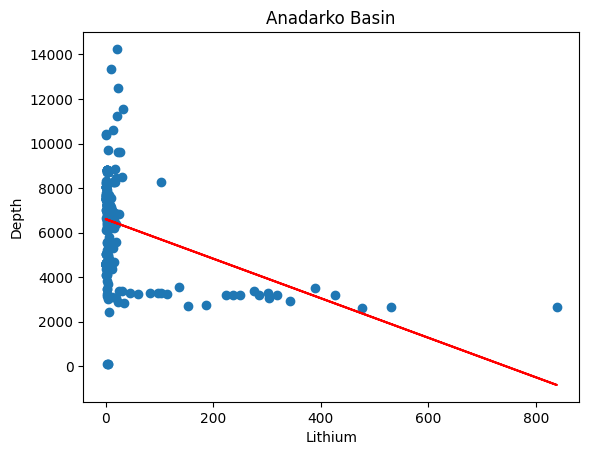

In [28]:
# Create linear regression plot for anadarko basin
linear_regression_plot(df_anadarko['Li'], df_anadarko['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Anadarko Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/anadarko_plot.png')

R value: 0.1544635817386964
Correlation coefficient (r): 0.3930185513925474


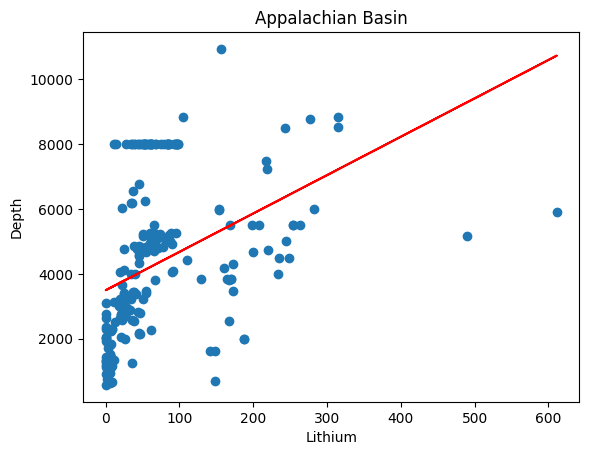

In [29]:
# Create linear regression plot for appalachain basin
linear_regression_plot(df_appalachian['Li'], df_appalachian['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Appalachian Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/appalachian_plot.png')

R value: 0.7427188008416605
Correlation coefficient (r): 0.8618113487542738


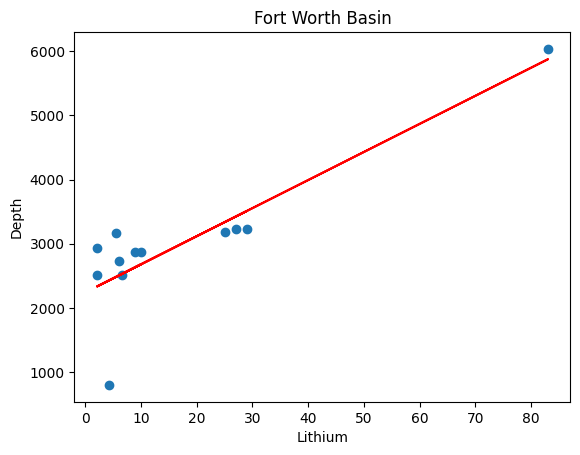

In [30]:
# Create linear regression plot for fort worth basin
linear_regression_plot(df_fort_worth['Li'], df_fort_worth['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Fort Worth Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/fort_worth_plot.png')

R value: 0.0007691435472727304
Correlation coefficient (r): 0.027733437350475156


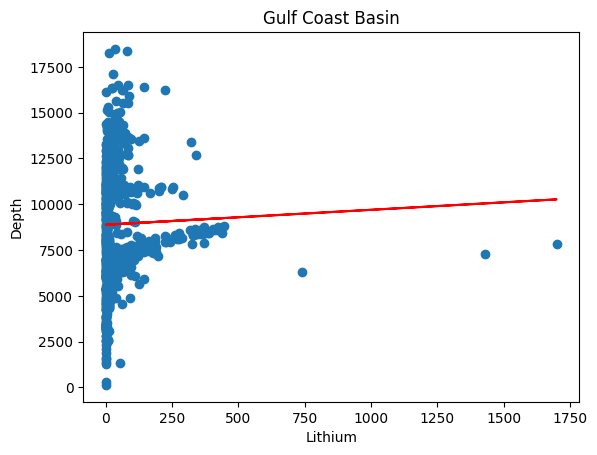

In [31]:
# Create linear regression plot for gulf coast basin
linear_regression_plot(df_gulf_coast['Li'], df_gulf_coast['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Gulf Coast Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/gulf_coast_plot.png')

R value: 0.19345479824579875
Correlation coefficient (r): 0.4398349670567345


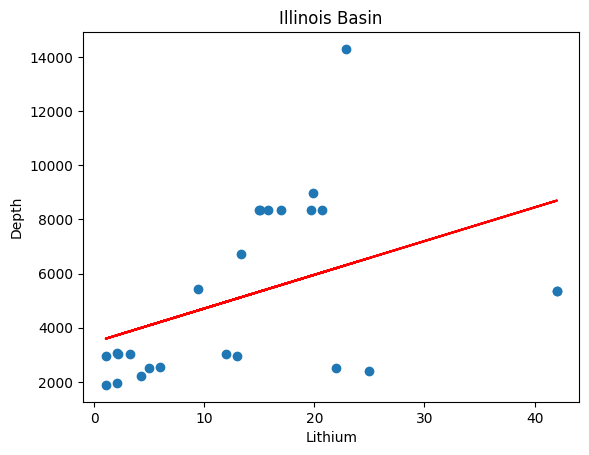

In [32]:
# Create linear regression plot for illinois basin
linear_regression_plot(df_illinois['Li'], df_illinois['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Illinois Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/illinois_plot.png')

R value: 0.4365571656935347
Correlation coefficient (r): 0.6607247276237924


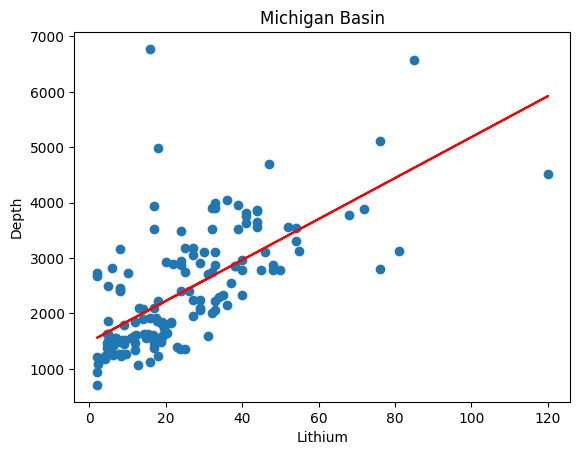

In [33]:
# Create linear regression plot for michigan basin
linear_regression_plot(df_michigan['Li'], df_michigan['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Michigan Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/michigan_plot.png')

R value: 0.0015860788048462937
Correlation coefficient (r): 0.03982560488989833


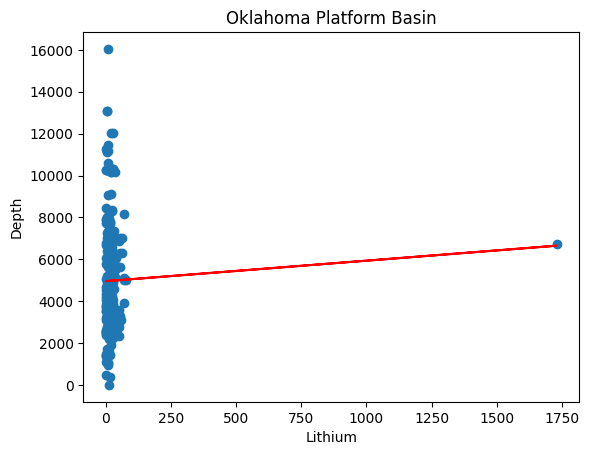

In [34]:
# Create linear regression plot for oklahoma platform basin
linear_regression_plot(df_oklahoma_platform['Li'], df_oklahoma_platform['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Oklahoma Platform Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/oklahoma_platform_plot.png')

R value: 0.003959750642966849
Correlation coefficient (r): -0.06292654958733117


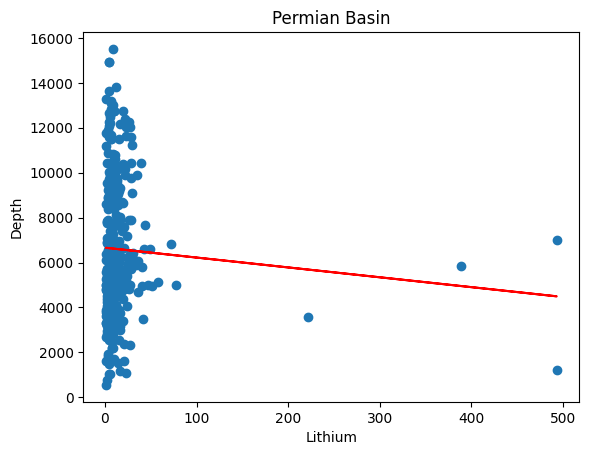

In [35]:
# Create linear regression plot for permian basin
linear_regression_plot(df_permian['Li'], df_permian['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Permian Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/permian_plot.png')

R value: 0.031623489693970185
Correlation coefficient (r): 0.17782994599889576


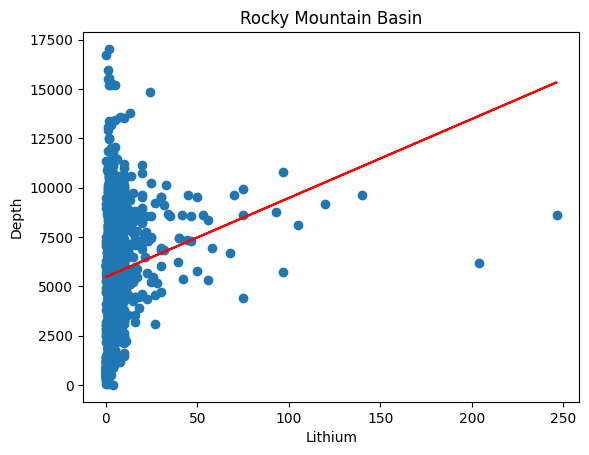

In [36]:
# Create linear regression plot for rocky mountain basin
linear_regression_plot(df_rocky_mountain['Li'], df_rocky_mountain['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Rocky Mountain Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/rocky_mountain_plot.png')

R value: 0.08666492308764755
Correlation coefficient (r): 0.29438906754097977


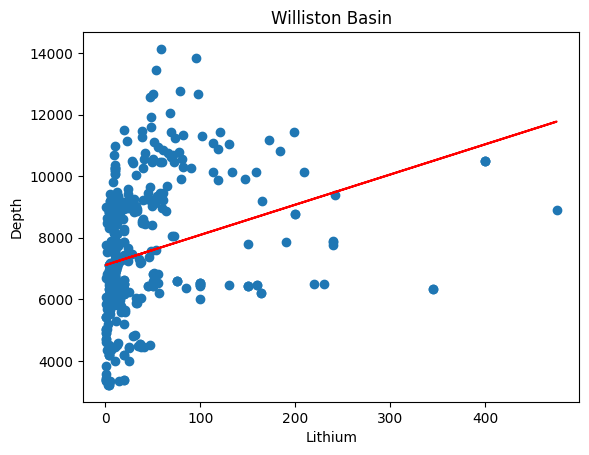

In [37]:
# Create linear regression plot for williston basin
linear_regression_plot(df_williston['Li'], df_williston['DEPTHUPPER'], 'Depth')
# Add title to the plot
plt.title('Williston Basin')
# Save the plot as an image
plt.savefig('../images/regression_plots/williston_plot.png')